**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
import pandas as pd

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Sliding window

In [18]:
def create_time_series_data(raw_train_df, nbf_features, nbf_outputs, column_key, column_suffix="", include_target_outputs=True):
    nbf_columns = nbf_features + nbf_outputs
    time_series_df, time_series = sliding_window_algorithm(raw_train_df, nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    return time_series, time_series_df


def sliding_window_algorithm(raw_data_df, nbf_columns, input_window, output_window, column_key, column_suffix, include_target_outputs, string_array=False):
    raw_data = raw_data_df[column_key].to_numpy()
    dim0 = raw_data.shape[0] - (nbf_columns - 1) # Number of time-slices
    dim1 = nbf_columns # Time-step length including input window and output window
    
    if string_array:
        data = np.empty((dim0,dim1), dtype=object) # Time series matrix
    else:
        data = np.zeros((dim0,dim1)) # Time series matrix

    data[0, :] = raw_data[:dim1] # First initial sample/time-slice (n equals 0)
    n = 1 # n is the count variable
    
    # Looping through the initial input data and constucting the 
    # time series data based on the sliding window approach. 
    # See the report for more descriptions
    for j in range(dim1, raw_data.shape[0]):
        data[n, :-1] = data[n-1, 1:]
        data[n, nbf_columns-1:] = raw_data[j]
        n += 1

    if include_target_outputs:
        # Creating dataframe    
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+1)]
        if(output_window > 1):
            output_names = [f"y{i}_{column_suffix}" for i in range(1,output_window+1)]    
        else:
            output_names = [f"y_{column_suffix}"]
        
        time_series_df = pd.DataFrame(data=data, columns=feature_names+output_names)
    else:
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+2)]
        time_series_df = pd.DataFrame(data=data, columns=feature_names)

    return time_series_df, data

# Basic RNNs

## Generate the Dataset

In [47]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 48
series = generate_time_series(10000, n_steps + 1)


X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f"{series.shape=}")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

# Own Dataset

In [92]:
# Training data
dataset_df = pd.read_csv("MAIN_DATASET.csv")[["NO5_price", "NO5_load_actual","NO5_load_delta", "NO5_generation_actual", "NO5_generation_delta", "dato_id","date_time"]][:-7381]; print(dataset_df.shape)

display(dataset_df.tail(3))


scaler = MinMaxScaler()
print("***",dataset_df["NO5_price"].values.reshape(-1,1).shape)

dataset_df["NO5_price"] = scaler.fit_transform(dataset_df["NO5_price"].values.reshape(-1,1))
dataset_df["NO5_load_actual"] = scaler.fit_transform(dataset_df["NO5_load_actual"].values.reshape(-1,1))
dataset_df["NO5_load_delta"] = scaler.fit_transform(dataset_df["NO5_load_delta"].values.reshape(-1,1))
dataset_df["NO5_generation_actual"] = scaler.fit_transform(dataset_df["NO5_generation_actual"].values.reshape(-1,1))
dataset_df["NO5_generation_delta"] = scaler.fit_transform(dataset_df["NO5_generation_delta"].values.reshape(-1,1))

# Forecast solutions
# training_df, forcast_sol_df = train_test_split(training_df, shuffle=False, test_size=0.2, random_state=4155)

# Displaying the loaded data
# display(training_df.tail(3))
# print(training_df.shape)
# display(forcast_sol_df.head(3))
# print(forcast_sol_df.shape)

# print(training_df.max())

# print(training_df.min())
# print(forcast_sol_df.max())
# print(forcast_sol_df.min())

(44280, 7)


,NO5_price,NO5_load_actual,NO5_load_delta,NO5_generation_actual,NO5_generation_delta,dato_id,date_time
44277,35.29,2490,-423,6910,-3275,2021-01-21 09:00:00+01:00,2021-01-21-09
44278,33.01,2499,-460,6568,-3186,2021-01-21 10:00:00+01:00,2021-01-21-10
44279,33.38,2460,-412,6722,-3267,2021-01-21 11:00:00+01:00,2021-01-21-11


*** (44280, 1)


In [240]:
# Time series slicing parameters
nbf_features = input_window = 48 
nbf_outputs = output_window = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")

# Lag
n_steps = 48

# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :-1], time_series[ :34272, -1:]
X_valid, y_valid = time_series[34272:34272+6581, :-1], time_series[34272:34272+6581, -1:]
X_test, y_test = time_series[34272+6581:, :-1], time_series[34272+6581:, -1:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44232, 49)
(44232, 49)
(34272, 48, 1) (34272, 1)
(6581, 48, 1) (6581, 1)
(3379, 48, 1) (3379, 1)


Saving figure time_series_plot


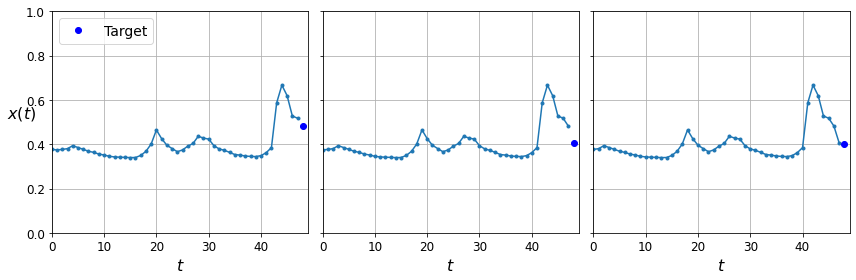

In [241]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.ylim(0,1)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. In the book, I first used blue crosses for targets and red dots for predictions, then I reversed this later in the chapter. Sorry if this caused some confusion.

## Computing Some Baselines

Naive predictions (just predict the last observed value):

In [242]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

1.8073636193339164e-05

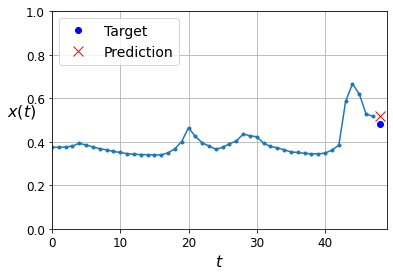

In [243]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[48, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1071/1071 [==============================] - 1s 682us/step - loss: 0.0015 - val_loss: 9.2537e-05
Epoch 2/20
1071/1071 [==============================] - 1s 564us/step - loss: 7.5820e-04 - val_loss: 6.1483e-05
Epoch 3/20
1071/1071 [==============================] - 1s 605us/step - loss: 5.5880e-04 - val_loss: 4.7448e-05
Epoch 4/20
1071/1071 [==============================] - 1s 588us/step - loss: 4.5985e-04 - val_loss: 4.1241e-05
Epoch 5/20
1071/1071 [==============================] - 1s 623us/step - loss: 3.9192e-04 - val_loss: 4.3713e-05
Epoch 6/20
1071/1071 [==============================] - 1s 642us/step - loss: 3.4989e-04 - val_loss: 3.2469e-05
Epoch 7/20
1071/1071 [==============================] - 1s 558us/step - loss: 3.2180e-04 - val_loss: 3.3781e-05
Epoch 8/20
1071/1071 [==============================] - 1s 560us/step - loss: 2.9939e-04 - val_loss: 3.0744e-05
Epoch 9/20
1071/1071 [==============================] - 1s 558us/step - loss: 2.8655e-04 - val_loss: 3.3547e

In [26]:
model.evaluate(X_valid, y_valid)

206/206 [==============================] - 0s 612us/step - loss: 1.9056e-05


1.9056185919907875e-05

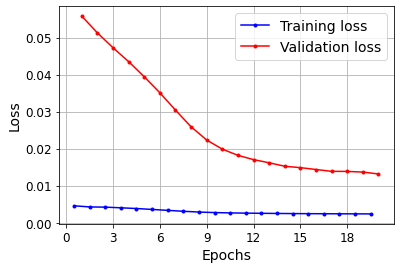

In [244]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

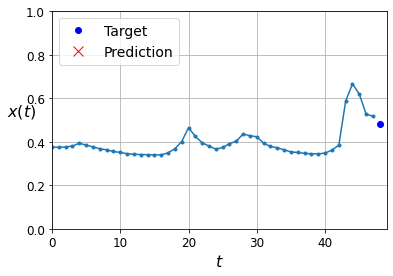

In [245]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Using a Simple RNN

In [246]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1071/1071 [==============================] - 4s 4ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 2/20
1071/1071 [==============================] - 4s 4ms/step - loss: 5.7357e-04 - val_loss: 0.0012
Epoch 3/20
1071/1071 [==============================] - 4s 4ms/step - loss: 4.8961e-04 - val_loss: 7.6715e-04
Epoch 4/20
1071/1071 [==============================] - 4s 3ms/step - loss: 4.1266e-04 - val_loss: 3.9576e-04
Epoch 5/20
1071/1071 [==============================] - 4s 3ms/step - loss: 3.4893e-04 - val_loss: 2.3253e-04
Epoch 6/20
1071/1071 [==============================] - 4s 3ms/step - loss: 3.0016e-04 - val_loss: 2.0025e-04
Epoch 7/20
1071/1071 [==============================] - 4s 4ms/step - loss: 2.6597e-04 - val_loss: 1.6765e-04
Epoch 8/20
1071/1071 [==============================] - 4s 3ms/step - loss: 2.4345e-04 - val_loss: 7.8349e-05
Epoch 9/20
1071/1071 [==============================] - 3s 3ms/step - loss: 2.3147e-04 - val_loss: 8.2246e-05
Epoch 10/20
1071/1071 

In [30]:
model.evaluate(X_valid, y_valid)

206/206 [==============================] - 0s 2ms/step - loss: 1.0739e-04


0.00010738553100964054

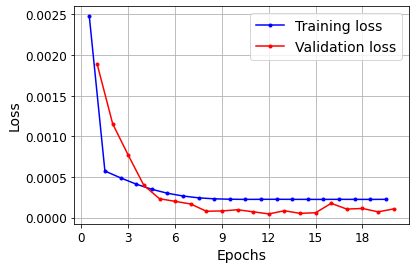

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

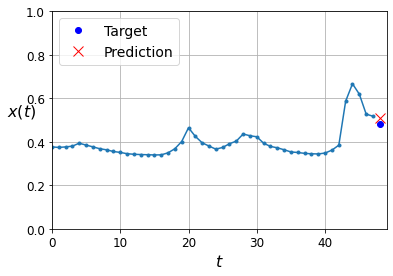

In [32]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1071/1071 [==============================] - 12s 11ms/step - loss: 0.0093 - val_loss: 0.0013
Epoch 2/20
1071/1071 [==============================] - 12s 11ms/step - loss: 8.0999e-04 - val_loss: 0.0165
Epoch 3/20
1071/1071 [==============================] - 12s 11ms/step - loss: 4.4866e-04 - val_loss: 0.0174
Epoch 4/20
1071/1071 [==============================] - 12s 11ms/step - loss: 4.0357e-04 - val_loss: 0.0037
Epoch 5/20
1071/1071 [==============================] - 12s 11ms/step - loss: 3.1222e-04 - val_loss: 1.9353e-04
Epoch 6/20
1071/1071 [==============================] - 12s 11ms/step - loss: 3.0098e-04 - val_loss: 1.1190e-04
Epoch 7/20
1071/1071 [==============================] - 12s 11ms/step - loss: 2.5741e-04 - val_loss: 1.0650e-04
Epoch 8/20
1071/1071 [==============================] - 12s 11ms/step - loss: 2.5696e-04 - val_loss: 1.7533e-04
Epoch 9/20
1071/1071 [==============================] - 12s 11ms/step - loss: 2.3297e-04 - val_loss: 5.8474e-05
Epoch 10/20


In [34]:
model.evaluate(X_valid, y_valid)

206/206 [==============================] - 1s 4ms/step - loss: 4.8015e-05


4.801488830707967e-05

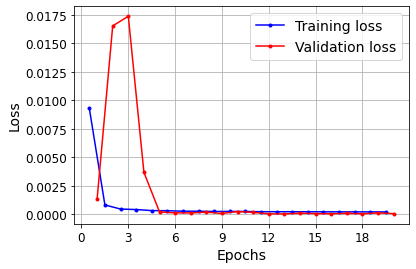

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

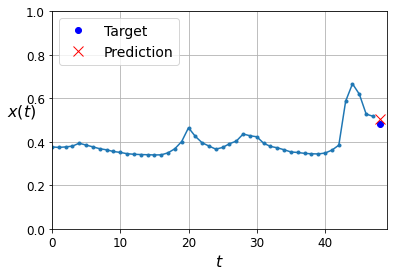

In [36]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [255]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))              

Epoch 1/20
1071/1071 [==============================] - 14s 13ms/step - loss: 0.0038 - val_loss: 1.6199e-04
Epoch 2/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0014 - val_loss: 9.4204e-04
Epoch 3/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0014 - val_loss: 5.9319e-04
Epoch 4/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0014 - val_loss: 6.8191e-04
Epoch 5/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0014 - val_loss: 6.4772e-04
Epoch 6/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0013 - val_loss: 5.6102e-04
Epoch 9/20
1071/1071 [==============================] - 12s 12ms/step - loss: 0.0013 - val_loss: 6.7912e-04
Epoch 10/20
1071/1071 [=============

In [278]:
print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{y_valid.shape=}")

eta = 0.002
batch_size = 100
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 72]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, nbf_features]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt)

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.shape)

history = model.fit(np.swapaxes(X_train, 1, 2), y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(np.swapaxes(X_valid, 1, 2), y_valid),
                    callbacks= callbacks)      

X_train.shape=(34272, 72, 1)
y_train.shape=(34272, 24)
X_valid.shape=(6581, 72, 1)
y_valid.shape=(6581, 24)
(34272, 72, 1)
(34272, 24)
Epoch 1/20
343/343 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0147
Epoch 2/20
343/343 [==============================] - 1s 3ms/step - loss: 0.0027 - val_loss: 0.0175
Epoch 3/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0190
Epoch 4/20
323/343 [===========================>..] - ETA: 0s - loss: 0.0032
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
343/343 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0187
Epoch 5/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0139
Epoch 6/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0113
Epoch 7/20
343/343 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 8/20
343/343 

In [280]:
model.evaluate(np.swapaxes(X_valid, 1,2), y_valid)

206/206 [==============================] - 0s 1ms/step - loss: 0.0055


0.0054967813193798065

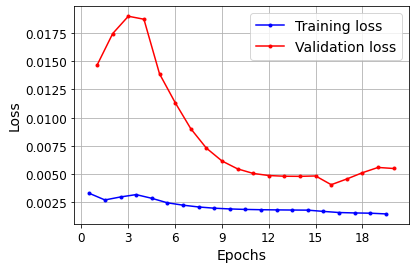

In [281]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

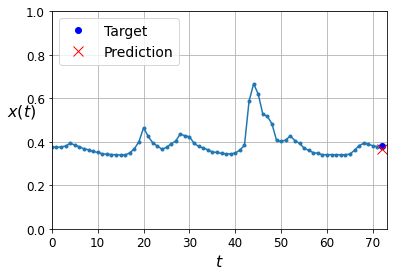

In [283]:
y_pred = model.predict(np.swapaxes(X_valid, 1,2))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [284]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 24

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44185, 96)
(44185, 96)
(34272, 72, 1) (34272, 24)
(6581, 72, 1) (6581, 24)
(3332, 72, 1) (3332, 24)


In [262]:
np.random.seed(43) # not 42, as it would give the first series in the train set
series = generate_time_series(1, n_steps + horizon)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")

X = X_new
for step_ahead in range(horizon):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

X_new.shape=(1, 72, 1)
Y_new.shape=(1, 24, 1)


In [313]:
np.random.seed(43) # not 42, as it would give the first series in the train set

X_new = X_test[-1:, :]
Y_new = np.expand_dims(y_test[-1:, :], 2)

display(dataset_df[["NO5_price", "date_time"]].tail(1))

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")

X = X_new
X = np.swapaxes(X_new, 1,2)

print(X.shape)

for step_ahead in range(horizon):
    # y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    y_pred_one = model.predict(X[:, :, step_ahead:])

    print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]

    # X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{y_pred_one.shape=}")

    X = np.concatenate([X, y_pred_one], axis=2)
    print(f"{X.shape=}")

print(f"{X.shape=}")
Y_pred = X[:, n_steps:]
Y_pred = X[:,:, n_steps:]


,NO5_price,date_time
44279,0.291576,2021-01-21-11


X_new.shape=(1, 72, 1)
Y_new.shape=(1, 24, 1)
(1, 1, 72)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 73)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 74)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 75)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 76)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 77)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 78)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 79)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 80)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 81)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 82)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 83)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 84)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1

In [315]:
print(Y_pred.shape)

Y_pred = np.swapaxes(Y_pred, 1,2)
# Y_pred = np.squeeze(Y_pred)

print(X_new.shape, Y_new.shape, Y_pred.shape)


(1, 1, 24)
(1, 72, 1) (1, 24, 1) (1, 24, 1)


Saving figure forecast_ahead_plot


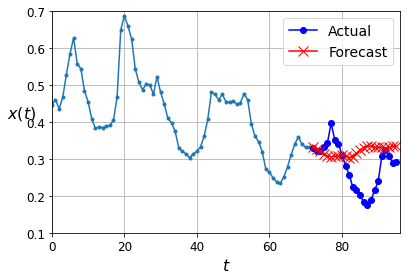

In [316]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.ylim(0,1)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.ylim(0.10,0.70)
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

# n_steps = 50
# series = generate_time_series(10000, n_steps + 10)
# X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
# X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
# X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [317]:
X = X_valid
for step_ahead in range(horizon):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

InvalidArgumentError:    Specified a list with shape [?,72] from a tensor with shape [32,1]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_56/lstm_76/PartitionedCall]] [Op:__inference_predict_function_612817]

Function call stack:
predict_function -> predict_function -> predict_function


In [146]:
Y_pred.shape

(6581, 24)

In [147]:
np.mean(keras.metrics.mean_squared_error(y_valid, Y_pred))

0.005463549756363638

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [149]:
Y_naive_pred = np.tile(X_valid[:, -1], horizon) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(y_valid, Y_naive_pred))

0.00015479788176902585

In [151]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(horizon)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1071/1071 [==============================] - 1s 711us/step - loss: 0.0044 - val_loss: 3.1098e-04
Epoch 2/20
1071/1071 [==============================] - 1s 673us/step - loss: 0.0015 - val_loss: 1.8626e-04
Epoch 3/20
1071/1071 [==============================] - 1s 644us/step - loss: 0.0013 - val_loss: 1.6538e-04
Epoch 4/20
1071/1071 [==============================] - 1s 665us/step - loss: 0.0011 - val_loss: 1.8567e-04
Epoch 5/20
1071/1071 [==============================] - 1s 739us/step - loss: 0.0011 - val_loss: 1.8516e-04
Epoch 6/20
1071/1071 [==============================] - 1s 648us/step - loss: 0.0011 - val_loss: 1.4038e-04
Epoch 7/20
1071/1071 [==============================] - 1s 648us/step - loss: 0.0010 - val_loss: 1.5431e-04
Epoch 8/20
1071/1071 [==============================] - 1s 774us/step - loss: 0.0010 - val_loss: 1.5829e-04
Epoch 9/20
1071/1071 [==============================] - 1s 670us/step - loss: 0.0010 - val_loss: 1.3307e-04
Epoch 10/20
1071/1071 [=====

Now let's create an RNN that predicts all 10 next values at once:

In [153]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1071/1071 [==============================] - 13s 13ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 2/20
1071/1071 [==============================] - 13s 13ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0014 - val_loss: 8.5230e-04
Epoch 4/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/20
1071/1071 [==============================] - 13s 12ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/20
1071/1071 [==============================] - 13s

In [154]:
np.random.seed(43)

# series = generate_time_series(1, 48 + 10)
# X_new, Y_new = series[:, :48, :], series[:, -10:, :]

Y_pred = model.predict(X_new)[..., np.newaxis]

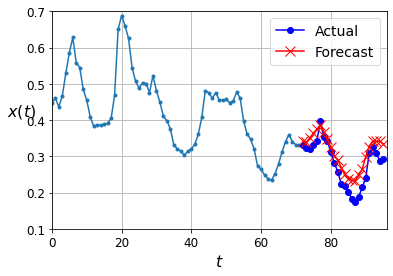

In [157]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.ylim(0.10,0.70)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)
# n_steps = 50
# series = generate_time_series(10000, n_steps + 10)
# X_train = series[:7000, :n_steps]
# X_valid = series[7000:9000, :n_steps]
# X_test = series[9000:, :n_steps]
# Y = np.empty((10000, n_steps, 10))
# for step_ahead in range(1, 10 + 1):
#     Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
# Y_train = Y[:7000]
# Y_valid = Y[7000:9000]
# Y_test = Y[9000:]

Y = np.empty((time_series.shape[0], n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n_steps, 0]

# Y_train = Y[:7000]
# Y_valid = Y[7000:9000]
# Y_test = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

In [166]:
np.random.seed(42)

#n_steps = 48
dataset_len = X_train.shape[0] + X_train.shape[1] + X_train.shape[2]

Y = np.empty((dataset_len, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[..., step_ahead - 1] = time_series[..., step_ahead:step_ahead + n_steps, 0]

print(f"{Y.shape=}")
Y_train = Y[:y_train.shape[0]]
Y_valid = Y[y_train.shape[0]:y_train.shape[0]+y_valid.shape[0]]
Y_test = Y[y_train.shape[0]+y_valid.shape[0]:]
# Y_train = Y[:7000]
# Y_valid = Y[7000:9000]
# Y_test = Y[9000:]

Y.shape=(34345, 72, 24)


In [167]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(34272, 72, 1) (34272, 72, 24)
(6581, 72, 1) (73, 72, 24)
(3332, 72, 1) (0, 72, 24)


In [160]:


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


ValueError: in user code:

    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10397 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 10 and 24 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_9/time_distributed/Reshape_1, IteratorGetNext:1)' with input shapes: [32,72,10], [32,72,24].


In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# Deep RNNs with Layer Norm

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# Creating a Custom RNN Class

In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# LSTMs

In [238]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 24
time_steps = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO5_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

# X_train = np.expand_dims(X_train, axis=1)
# X_valid = np.expand_dims(X_valid, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

train_start_idx = X_train.shape[0]%time_steps
X_train = X_train[train_start_idx: , :] # 
y_train = y_train[train_start_idx: , :] # 

batch_size_train = X_train.shape[0] // time_steps
x_train_RNN = X_train.reshape((batch_size_train, time_steps, nbf_features))
y_train_RNN = y_train.copy()
y_train_RNN = y_train_RNN.reshape((batch_size_train, time_steps, nbf_outputs))


# Validation 
valid_start_idx = X_valid.shape[0]%time_steps
X_valid = X_valid[valid_start_idx: , :] # 
y_valid = y_valid[valid_start_idx: , :] # 

batch_size_valid = X_valid.shape[0] // time_steps
x_valid_RNN = X_valid.reshape((batch_size_valid, time_steps, nbf_features))
y_valid_RNN = y_valid.copy()
y_valid_RNN = y_valid_RNN.reshape((batch_size_valid, time_steps, nbf_outputs))

# Test 
test_start_idx = X_test.shape[0]%time_steps
X_test = X_test[test_start_idx: , :] # 
y_test = y_test[test_start_idx: , :] # 

batch_size_test = X_test.shape[0] // time_steps
x_test_RNN = X_test.reshape((batch_size_test, time_steps, nbf_features))
y_test_RNN = y_test.copy()
y_test_RNN = y_test_RNN.reshape((batch_size_test, time_steps, nbf_outputs))


X_train = x_train_RNN   
y_train = y_train_RNN   

X_train = x_train_RNN   
y_train = y_train_RNN   

X_train = x_train_RNN   
y_train = y_train_RNN   
print("After")
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44185, 96)
(44185, 96)
(34272, 72) (34272, 24)
(6581, 72) (6581, 24)
(3332, 72) (3332, 24)
After
(34272, 72) (34272, 24)
(6581, 72) (6581, 24)
(3332, 72) (3332, 24)


In [237]:
np.random.seed(42)
tf.random.set_seed(42)

eta = 0.002
batch_size = 100

model = keras.models.Sequential([
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, nbf_features]),
    # keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt, metrics=[last_time_step_mse])

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.shape)

history = model.fit(X_train, y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks= callbacks)

(34272, 72)
(34272, 24)
Epoch 1/20


ValueError: in user code:

    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\andre\anaconda3\envs\fysstk1\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_40 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 72]


In [200]:
model.evaluate(X_valid, y_valid)

206/206 [==============================] - 2s 8ms/step - loss: 0.0132 - last_time_step_mse: 0.0122


[0.013160488568246365, 0.012176884338259697]

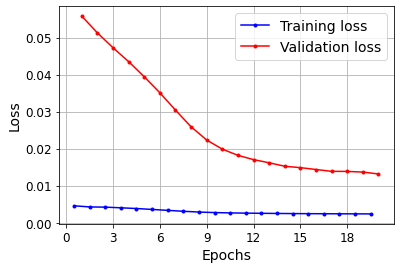

In [202]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [204]:
np.random.seed(43)

# series = generate_time_series(1, 50 + 10)
# X_new, Y_new = series[:, :50, :], series[:, 50:, :]

print(f"{X_test.shape=}")

X_new = X_test[-1:, :]
Y_new = np.expand_dims(y_test[-1:, :], 2)

Y_pred = model.predict(X_new)
print(f"Before: {Y_pred.shape=}")

Y_pred = Y_pred[:, -1][..., np.newaxis]

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")
print(f"After: {Y_pred.shape=}")

X_test.shape=(3355, 72, 1)
Before: Y_pred.shape=(1, 72, 1)
X_new.shape=(1, 72, 1)
Y_new.shape=(1, 1, 1)
After: Y_pred.shape=(1, 1, 1)


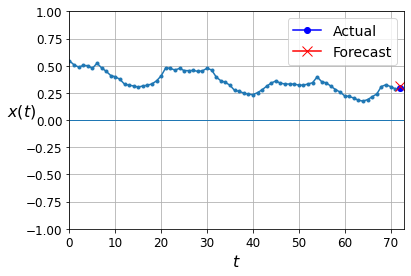

In [179]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [190]:
np.random.seed(42)
tf.random.set_seed(42)

eta = 0.002
batch_size = 100

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])

opt = tf.keras.optimizers.Adam(learning_rate=eta)

model.compile(loss="mse", optimizer=opt, metrics=[last_time_step_mse])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)
callbacks = [learning_rate_reduction]

history = model.fit(X_train, y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks= callbacks)

Epoch 1/20
343/343 [==============================] - 12s 35ms/step - loss: 0.0034 - last_time_step_mse: 0.0022 - val_loss: 0.0310 - val_last_time_step_mse: 0.0310
Epoch 2/20
343/343 [==============================] - 14s 41ms/step - loss: 0.0028 - last_time_step_mse: 0.0020 - val_loss: 0.0302 - val_last_time_step_mse: 0.0300
Epoch 3/20
343/343 [==============================] - 15s 45ms/step - loss: 0.0029 - last_time_step_mse: 0.0020 - val_loss: 0.0303 - val_last_time_step_mse: 0.0300
Epoch 4/20
343/343 [==============================] - 15s 44ms/step - loss: 0.0029 - last_time_step_mse: 0.0021 - val_loss: 0.0301 - val_last_time_step_mse: 0.0297
Epoch 5/20
343/343 [==============================] - 14s 42ms/step - loss: 0.0029 - last_time_step_mse: 0.0021 - val_loss: 0.0290 - val_last_time_step_mse: 0.0287
Epoch 6/20
343/343 [==============================] - 14s 42ms/step - loss: 0.0029 - last_time_step_mse: 0.0020 - val_loss: 0.0276 - val_last_time_step_mse: 0.0272
Epoch 7/20
343/3

In [191]:
model.evaluate(X_valid, y_valid)

206/206 [==============================] - 2s 9ms/step - loss: 0.0116 - last_time_step_mse: 0.0104


[0.01157708466053009, 0.010439862497150898]

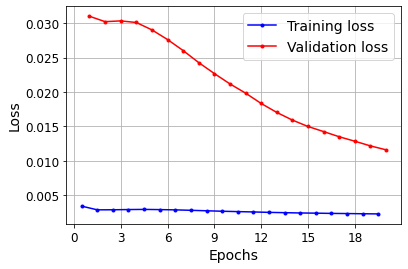

In [192]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [195]:
np.random.seed(43)

# series = generate_time_series(1, 50 + 10)
# X_new, Y_new = series[:, :50, :], series[:, 50:, :]
# Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
X_new = X_test[-1:, :]
Y_new = np.expand_dims(y_test[-1:, :], 2)
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

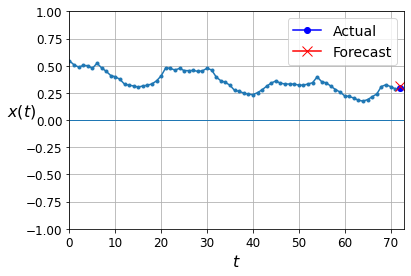

In [196]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 8.

See Appendix A.

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
train_files

In [ ]:
eval_files

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Now we're ready to compile and train the model!

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

**Warning**: `model.predict_classes(X)` is deprecated. It is replaced with `np.argmax(model.predict(X), axis=-1)`.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")